In [35]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import openpyxl

#Import pipeline functions
import recist_and_volume_calculator as rc


In [36]:
#lets open a test image
path = '/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/Processed/Lung_Dx-A0012_(DL)'
image = sitk.ReadImage(os.path.join(path,'image.nrrd'))
spacing = image.GetSpacing()
image_array = sitk.GetArrayFromImage(image)
dl_mask_array = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(path,'DL_mask.nrrd')))

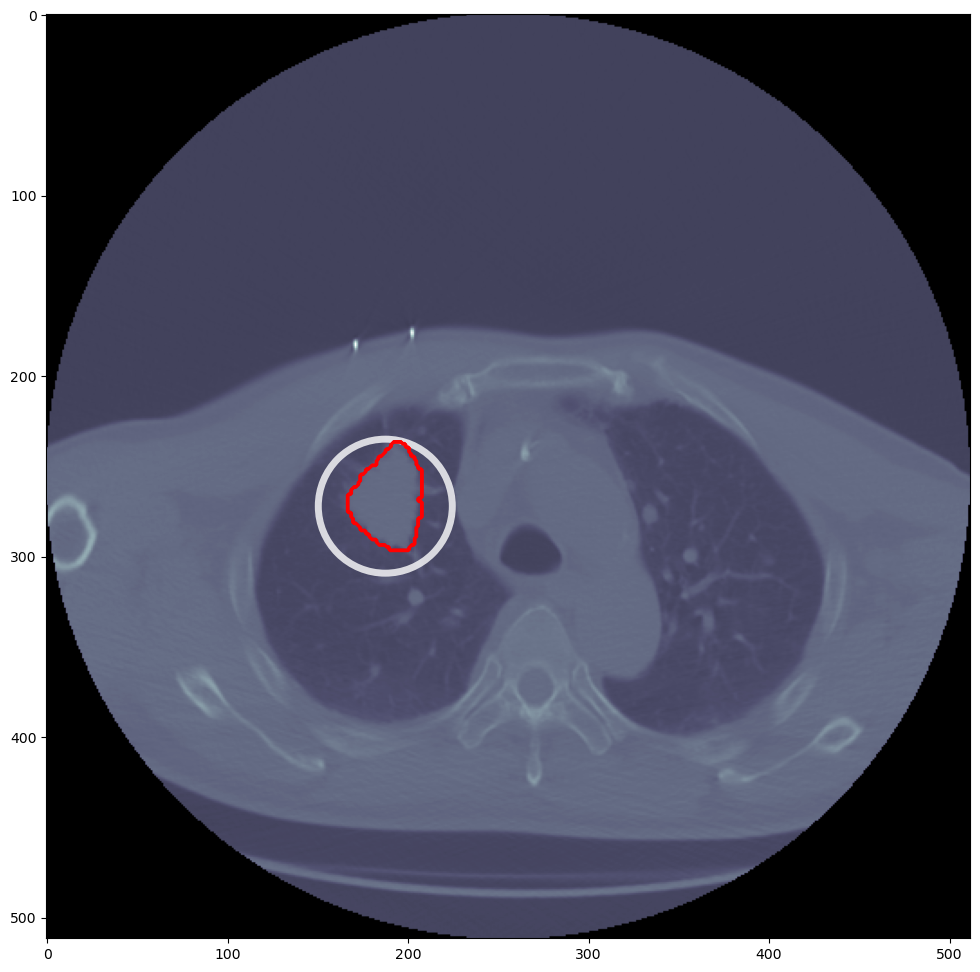

----------------------------------------
Predicted RECIST: 42 mm
Predicted tumor volume: 17.33 ml
----------------------------------------


In [37]:
##Calculate metrics
recist_predicted,volume_predicted,idx,circle = rc.calculate_values(dl_mask_array,spacing)
circle1 = plt.Circle((circle[1], circle[0]), circle[2]*2, color='white',fill=False,alpha=0.8, lw=5)

plt.figure(figsize=(12,12))
plt.imshow(image_array[idx,...],cmap='bone')
plt.contour(dl_mask_array[idx,...],colors='r')
fig = plt.gcf()
ax = fig.gca()
ax.add_patch(circle1)
plt.show()

print('-'*40)
print('Predicted RECIST: %s mm'%recist_predicted) 
print('Predicted tumor volume: %s ml'%volume_predicted)
print('-'*40)

In [38]:
import os
import pandas as pd
import SimpleITK as sitk
import recist_and_volume_calculator as rc  # your module

def process_patient_folder(folder_path):
    """
    Process a single patient folder and compute RECIST and volume metrics using rc.calculate_values.

    Args:
        folder_path (str): Path to patient folder containing image.nrrd and DL_mask.nrrd

    Returns:
        dict or None: Metrics dict or None if error/missing files
    """
    try:
        patient_id = os.path.basename(folder_path)
        image_path = os.path.join(folder_path, 'image.nrrd')
        mask_path = os.path.join(folder_path, 'DL_mask.nrrd')

        if not os.path.exists(image_path) or not os.path.exists(mask_path):
            print(f"Missing files for patient {patient_id}")
            return None

        image = sitk.ReadImage(image_path)
        spacing = image.GetSpacing()
        mask_array = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

        # Calculate metrics with your rc module function
        recist, volume, idx, circle = rc.calculate_values(mask_array, spacing)

        return {
            'patient_id': patient_id,
            'recist_mm': recist,
            'volume_ml': volume,
            'slice_index': idx
        }
    except Exception as e:
        print(f"Error processing patient {os.path.basename(folder_path)}: {str(e)}")
        return None

def scan_directory(base_directory, output_csv):
    """
    Scan all patient folders in base_directory, calculate tumor metrics, and save results to CSV.

    Args:
        base_directory (str): Directory containing patient subfolders
        output_csv (str): Path to save output CSV file
    """
    results = []
    for item in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, item)
        if os.path.isdir(folder_path):
            print(f"Processing patient: {item}")
            data = process_patient_folder(folder_path)
            if data:
                results.append(data)

    if results:
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f"Results saved to {output_csv}")
        print(f"Total patients processed: {len(results)}")
        return df
    else:
        print("No results found.")
        return None

In [39]:
# Répertoire de base contenant les dossiers patients
base_dir = '/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/Processed'
output_file = 'resultats_tumeurs.csv'

# Scanner tous les patients et créer un CSV
results_df = scan_directory(base_dir, output_file)
print(results_df)

Processing patient: Lung_Dx-B0020_(DL)
Processing patient: Lung_Dx-A0200_(DL)
Processing patient: Lung_Dx-A0096_(DL)
Processing patient: Lung_Dx-A0071_(DL)
Processing patient: Lung_Dx-A0107_(DL)
Processing patient: Lung_Dx-A0142_(DL)
Processing patient: Lung_Dx-A0134_(DL)
Processing patient: Lung_Dx-G0039_(DL)
Processing patient: Lung_Dx-A0056_(DL)
Processing patient: Lung_Dx-A0109_(DL)
Processing patient: Lung_Dx-A0097_(DL)
Processing patient: Lung_Dx-B0041_(DL)
Processing patient: Lung_Dx-G0015_(DL)
Error processing patient Lung_Dx-G0015_(DL): local variable 'circ' referenced before assignment
Processing patient: Lung_Dx-A0022_(DL)
Processing patient: Lung_Dx-A0254_(DL)
Processing patient: Lung_Dx-A0078_(DL)
Processing patient: Lung_Dx-A0223_(DL)
Processing patient: Lung_Dx-A0039_(DL)
Error processing patient Lung_Dx-A0039_(DL): local variable 'circ' referenced before assignment
Processing patient: Lung_Dx-G0049_(DL)
Processing patient: Lung_Dx-A0137_(DL)
Processing patient: Lung_Dx-

In [40]:
# Charger les données cliniques
clinical_data = pd.read_excel('/mounts/Datasets4/pred_lung_cancer/NIH dataset_raw/statistics-clinical-20201221.xlsx')

# Fonction pour extraire l'ID dans le format A0056 à partir de strings comme "Lung_Dx-A0056_(DL)"
def extract_subject_id(id_string):
    if isinstance(id_string, str):
        # Recherche du pattern A suivi de chiffres
        match = re.search(r'A\d+', id_string)
        if match:
            return match.group(0)
    return None

# Ajout d'une colonne avec l'ID extrait dans le format uniforme
results_df['NewPatientID'] = results_df['patient_id'].apply(extract_subject_id)

# Sélectionner seulement les données T-stage du dataframe clinique
t_stage_data = clinical_data[['NewPatientID', 'T-Stage']]

# Merger les deux dataframes sur la colonne subject_id
combined_data = pd.merge(
    results_df[['NewPatientID', 'recist_mm']], 
    t_stage_data,
    on='NewPatientID',
    how='inner'  # pour ne garder que les correspondances
)

# Afficher le résultat final
print("\nCombined data (T-stage et RECIST size):")
print(combined_data)

# Sauvegarder les données combinées
combined_data.to_csv('combined_t_stage_recist.csv', index=False)


Combined data (T-stage et RECIST size):
    NewPatientID  recist_mm T-Stage
0          A0200         31      1c
1          A0096         14      1c
2          A0071         64       2
3          A0107         38      1c
4          A0142         35       2
..           ...        ...     ...
187        A0139         94       4
188        A0144         84       2
189        A0090         47      1c
190        A0036         34      1c
191        A0044         31      1c

[192 rows x 3 columns]


In [41]:
# Stage ranking to map T-stage to a numerical scale
stage_order = {
    '0': 0,
    '1a': 1,
    '1b': 2,
    '1c': 3,
    '2a': 4,
    '2b': 5,
    '3': 6,
    '4': 7
}


def get_correct_t_stage(size_mm):
    if size_mm == 0:
        return '0'
    elif size_mm <= 10:
        return '1a'
    elif size_mm <= 20:
        return '1b'
    elif size_mm <= 30:
        return '1c'
    elif size_mm <= 40:
        return '2a'
    elif size_mm <= 50:
        return '2b'
    elif size_mm <= 70:
        return '3'
    else:
        return '4'


# Apply function to compute correct T-stage
combined_data['Model_T-Stage'] = combined_data['recist_mm'].apply(get_correct_t_stage)

# Compare only the first character of each T-stage
combined_data['Match'] = np.where(
    combined_data['T-Stage'].astype(str).str.strip().str.len() == 1,
    combined_data['Model_T-Stage'].astype(str).str.strip().str[0] ==
    combined_data['T-Stage'].astype(str).str.strip().str[0],
    combined_data['Model_T-Stage'].astype(str).str.strip() ==
    combined_data['T-Stage'].astype(str).str.strip()
)

# Output results
print("Full Verification Table:")
print(combined_data)


Full Verification Table:
    NewPatientID  recist_mm T-Stage Model_T-Stage  Match
0          A0200         31      1c            2a  False
1          A0096         14      1c            1b  False
2          A0071         64       2             3  False
3          A0107         38      1c            2a  False
4          A0142         35       2            2a   True
..           ...        ...     ...           ...    ...
187        A0139         94       4             4   True
188        A0144         84       2             4  False
189        A0090         47      1c            2b  False
190        A0036         34      1c            2a  False
191        A0044         31      1c            2a  False

[192 rows x 5 columns]


In [42]:
def compute_error(row):
    if not row['Match']:
        try:
            model_stage = str(row['Model_T-Stage']).strip().lower()
            actual_stage = str(row['T-Stage']).strip().lower()

            # Handle special case: if Model_T-Stage is exactly "2", treat it as "2a"
            if actual_stage == '2':
                actual_stage = '2a'

            actual = int(stage_order.get(actual_stage, -1))
            predicted = int(stage_order.get(model_stage, -1))

            return abs(actual - predicted)
        except (ValueError, TypeError):
            return np.nan
    else:
        return 0
    
combined_data['Stage_Error'] = combined_data.apply(compute_error, axis=1)

# Output results
print("Full Verification Table:")
print(combined_data)

Full Verification Table:
    NewPatientID  recist_mm T-Stage Model_T-Stage  Match  Stage_Error
0          A0200         31      1c            2a  False            1
1          A0096         14      1c            1b  False            1
2          A0071         64       2             3  False            2
3          A0107         38      1c            2a  False            1
4          A0142         35       2            2a   True            0
..           ...        ...     ...           ...    ...          ...
187        A0139         94       4             4   True            0
188        A0144         84       2             4  False            3
189        A0090         47      1c            2b  False            2
190        A0036         34      1c            2a  False            1
191        A0044         31      1c            2a  False            1

[192 rows x 6 columns]


# Statistics

=== Global Statistics ===
Total cases: 192
Correct predictions: 62
Incorrect predictions: 130
Error percentage: 67.71%
Number of '0' in Model_T-Stage: 0
Mean Stage Error: 1.19
Median Stage Error: 1.00
Min / Max Stage Error: 0.00 / 7.00

=== Mean Error by Actual T-Stage ===
T-Stage
2     1.405405
3     0.600000
4     0.400000
1a    2.800000
1b    1.083333
1c    1.172840
2a    1.222222
2b    1.125000
is    7.000000
Name: Stage_Error, dtype: float64

=== Errors Count by Actual T-Stage ===
T-Stage
2     24
3     15
4      2
1a     5
1b     6
1c    57
2a    13
2b     7
is     1
dtype: int64

✅ Report saved: 'model_t_stage_error_report.csv'


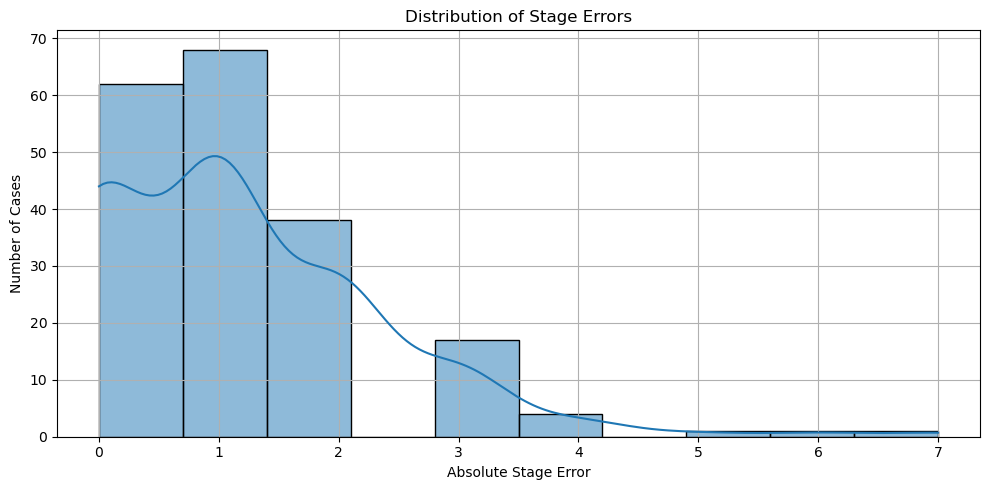

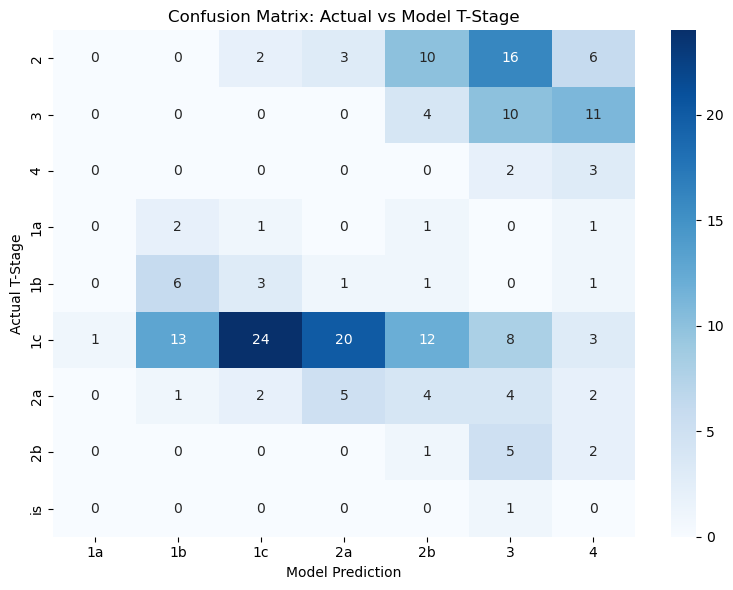

In [43]:
num_total = len(combined_data)
num_correct = combined_data['Match'].sum()
num_incorrect = num_total - num_correct
error_percentage = (num_incorrect / num_total) * 100
model_0_count = combined_data['Model_T-Stage'].astype(str).str.strip().eq('0').sum()
mean_stage_error = combined_data['Stage_Error'].mean()
median_stage_error = combined_data['Stage_Error'].median()
max_stage_error = combined_data['Stage_Error'].max()
min_stage_error = combined_data['Stage_Error'].min()

# Print results
print("=== Global Statistics ===")
print(f"Total cases: {num_total}")
print(f"Correct predictions: {num_correct}")
print(f"Incorrect predictions: {num_incorrect}")
print(f"Error percentage: {error_percentage:.2f}%")
print(f"Number of '0' in Model_T-Stage: {model_0_count}")
print(f"Mean Stage Error: {mean_stage_error:.2f}")
print(f"Median Stage Error: {median_stage_error:.2f}")
print(f"Min / Max Stage Error: {min_stage_error:.2f} / {max_stage_error:.2f}")

# Mean error by actual T-Stage
error_by_stage = combined_data.groupby('T-Stage')['Stage_Error'].mean()
print("\n=== Mean Error by Actual T-Stage ===")
print(error_by_stage)

# Number of errors per T-Stage
errors_per_stage = combined_data[~combined_data['Match']].groupby('T-Stage').size()
print("\n=== Errors Count by Actual T-Stage ===")
print(errors_per_stage)

# Save to CSV
report_df = combined_data.copy()
report_df['Error (%)'] = np.where(report_df['Match'], 0, 100)
report_df.to_csv("model_t_stage_error_report.csv", index=False)
print("\n✅ Report saved: 'model_t_stage_error_report.csv'")

# === Visualizations ===

# Histogram of stage errors
plt.figure(figsize=(10, 5))
sns.histplot(combined_data['Stage_Error'].dropna(), bins=10, kde=True)
plt.title('Distribution of Stage Errors')
plt.xlabel('Absolute Stage Error')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confusion matrix: actual vs predicted
conf_matrix = pd.crosstab(combined_data['T-Stage'], combined_data['Model_T-Stage'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix: Actual vs Model T-Stage')
plt.xlabel('Model Prediction')
plt.ylabel('Actual T-Stage')
plt.tight_layout()
plt.show()
